## Atmospheric effects on Ground Based Telescope Observing Bands
This notebook uses a python script to calculate and plot CMB instrument sensitivity to fluctuations in atmospheric pwv, given band shapes.

In [2]:
##### import matplotlib.pyplot as plt
#edit
import numpy as np
import matplotlib.pyplot as plt
import yaml

from Atmos_pwv_funcs import *

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8, 6]

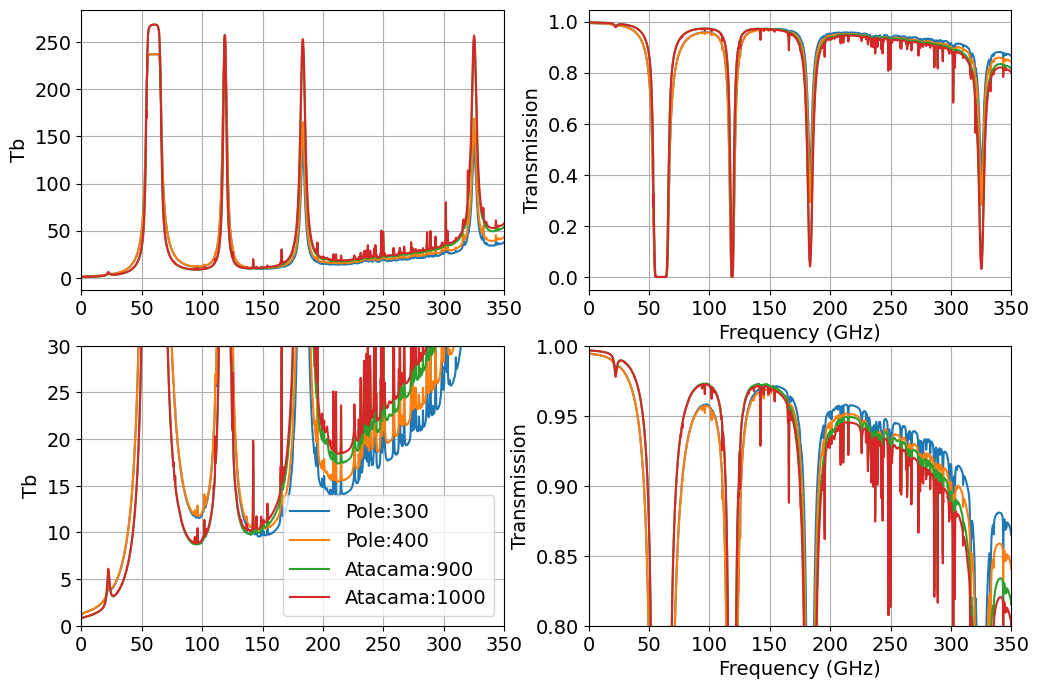

In [33]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 8]

# Read in atmospheric data, plot it to see that it makes sense.
atmos = {}
read_atmospheres(atmos)

numax = 350
plt.subplot(2,2,1)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][1])
plt.ylabel('Tb')
plt.xlim(0,numax)
plt.grid()

plt.subplot(2,2,2)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][2])
plt.ylabel('Transmission')
plt.xlabel('Frequency (GHz)')
plt.xlim(0,numax)
plt.grid()

plt.subplot(2,2,3)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        pltlabel=site+':'+str(pwv)
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][1],label=pltlabel)
plt.legend()
plt.ylabel('Tb')
plt.xlim(0,numax)
plt.ylim(0,30)
plt.grid()

plt.subplot(2,2,4)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][2])
plt.ylabel('Transmission')
plt.xlabel('Frequency (GHz)')
plt.xlim(0,numax)
plt.ylim(0.8,1.0)
plt.grid()



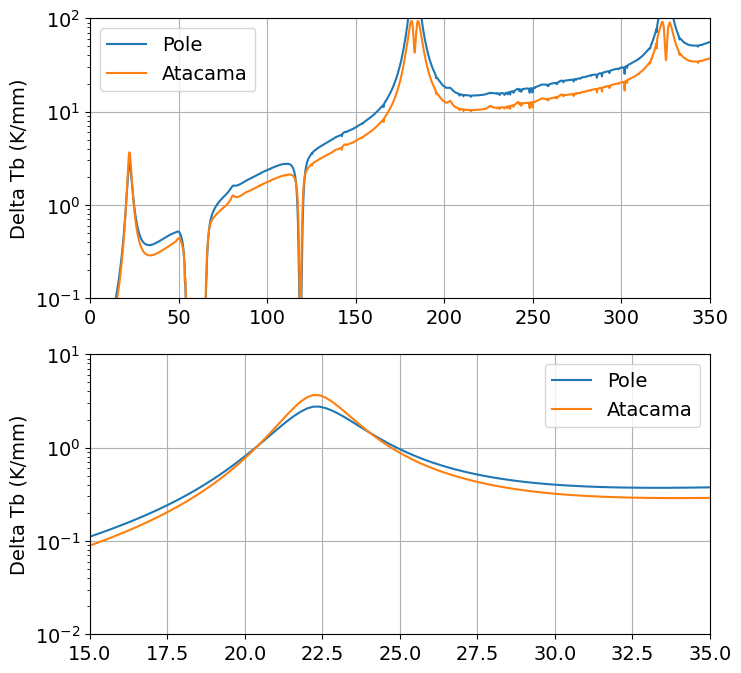

In [65]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [8, 8]

# plot Tb differences between pwvs
nuvec = atmos['Pole'][400][0]
Tbdiff_pole = 10*(atmos['Pole'][400][1]-atmos['Pole'][300][1])  #K/mm
Tbdiff_atacama = 10*(atmos['Atacama'][1000][1]-atmos['Atacama'][900][1])  #K/mm

plt.subplot(2,1,1)
plt.semilogy(nuvec,Tbdiff_pole,label='Pole')
plt.semilogy(nuvec,Tbdiff_atacama,label='Atacama')
plt.ylabel('Delta Tb (K/mm)')
plt.legend()
plt.xlim(0,350)
plt.ylim(0.1,100)
plt.grid()

plt.subplot(2,1,2)
plt.semilogy(nuvec,Tbdiff_pole,label='Pole')
plt.semilogy(nuvec,Tbdiff_atacama,label='Atacama')
plt.ylabel('Delta Tb (K/mm)')
plt.legend()
plt.xlim(15,35)
plt.ylim(0.01,10)
plt.grid()

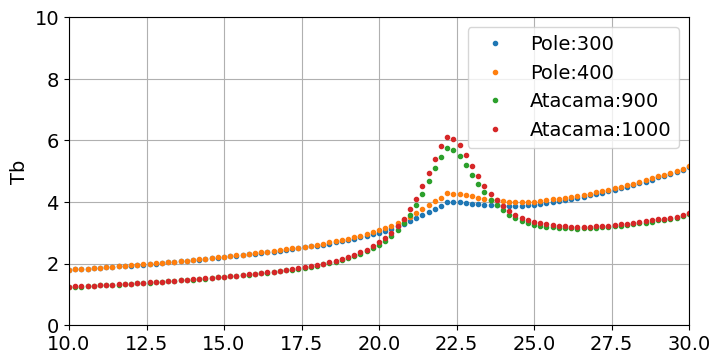

In [46]:
# Look at 22GHz water line more closely.
# Shape of Pole line is weird, maybe suspicious.  Should verify with direct am runs with
# better frequency resolution.

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [8, 4]

numax = 30

for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        pltlabel=site+':'+str(pwv)
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][1],'.',label=pltlabel)
plt.legend()
plt.ylabel('Tb')
#plt.xlim(10,numax)
plt.xlim(10,30)
plt.ylim(0,10)
plt.grid()


# Outline

*We've been using jbolo to facilitate the calculation of g_pwv because it then includes all the frequency 
dependence of the optics and the atmophsere.  The major frequency-dependent component of the optics is the 
Lyot stop.  We can treat the problem more generally by considering two designs, for two limits of Lyot-stop
illumination.*

1. Calculate single-moded, single-polarization instrument band response, ie to atmosphere.
  - F_inst($\nu$) = F_detector($\nu$) \* F_lyot($\nu$)
  - F_detector($\nu$) from logistic detector band
  - F_lyot($\nu$) depends on amount of spillover:
    - low spill Lyot stop => nearly frequency independent.
    - high spill lyot stop => efficiency of that is \propto nu^2
  
  
2. Integrate Tb_atmos($\nu$) over F_inst($\nu$) to get dPopt_atmosphere/dpwv.


3. Calculate response to delta_T_cmb
  - F_tot($\nu$) = F_inst($\nu$) * F_atmos($\nu$)
  - Integrate delta_T_cmb over F_tot($\nu$) to get dPopt_cmb/dT_cmb
  
  
4. Take the ratio of those two, g_pwv = (dPopt_atmosphere/dpwv)/(dPopt_cmb/dT_cmb) = dT_cmb/dpwv .

# Read in band information from a yaml file
(using same dictionary format as jbolo, for compatibility)

In [3]:
sim = yaml.safe_load(open('channels.yaml'))

In [4]:
sim['channels']

{'ULF': {'chnum': 0, 'band_center': 20.0, 'nu_low': 17.5, 'nu_high': 22.5},
 'LF_1': {'chnum': 1, 'band_center': 25.75, 'nu_low': 21.5, 'nu_high': 30.0},
 'LF_2': {'chnum': 2, 'band_center': 38.75, 'nu_low': 29.99, 'nu_high': 47.51},
 'MF_1': {'chnum': 3, 'band_center': 91.5, 'nu_low': 77.0, 'nu_high': 106.0},
 'MF_2': {'chnum': 4, 'band_center': 148.5, 'nu_low': 128.0, 'nu_high': 169.0},
 'HF_1': {'chnum': 5,
  'band_center': 227.0,
  'nu_low': 197.94,
  'nu_high': 256.06},
 'HF_2': {'chnum': 6,
  'band_center': 285.5,
  'nu_low': 255.95,
  'nu_high': 315.05}}

Text(0.5, 1.0, 'Model LF1 Band')

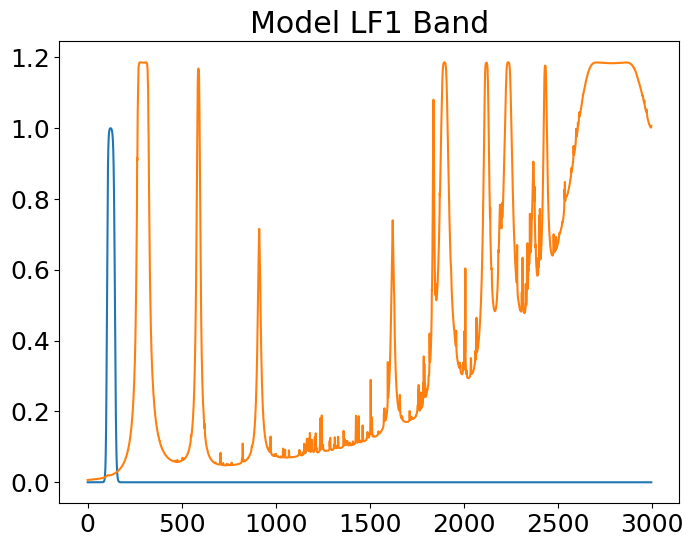

In [5]:
#test run to see band shape with logistic model
dnu= sim['channels']['LF_1']['nu_high']-sim['channels']['LF_1']['nu_low']
#print(dnu)
model1=logistic_bandmodel(atmos['Pole'][300][0], sim['channels']['LF_1']['band_center'], dnu, 2, 0.7)

plt.plot(model1)
plt.plot(atmos['Pole'][300][1]/200)
#plt.xlim(0,350)
plt.title('Model LF1 Band')

Comment on plot above:

- we might want to make band smaller for LF so we are not integrating over the whole thing (all freq)

In [6]:
dpdtcmb= calc_dPdTcmb(atmos['Pole'][300][0], atmos['Pole'][400][0], sim['channels']['LF_1']['band_center'], dnu, 2, 0.7, 2)
print('dPdTcmb:', dpdtcmb)

dPdTcmb: 2.3575717163473365e-13


In [7]:
dPdpwv= calc_dPdpwv(atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], sim['channels']['LF_1']['band_center'], dnu, 2, 0.7, 2)
print('dPdpwv:', dPdpwv)

dPdpwv: 2.7468623474186294e-12


In [8]:
gpwv= calc_gpwv(dPdpwv, dpdtcmb)
print('gpwv:', gpwv)

gpwv: 11.6512355843598


Given the results, the functions seem to be working well. We need to review them again to see if we're missing anything in regard to the lyot/optics.

In [9]:
#this section visualizes the alpha bandmodel function, play with the alpha parameter (0 or 2)
band=alpha_bandmodel(atmos['Pole'][300][0], sim['channels']['LF_1']['band_center'], 2)

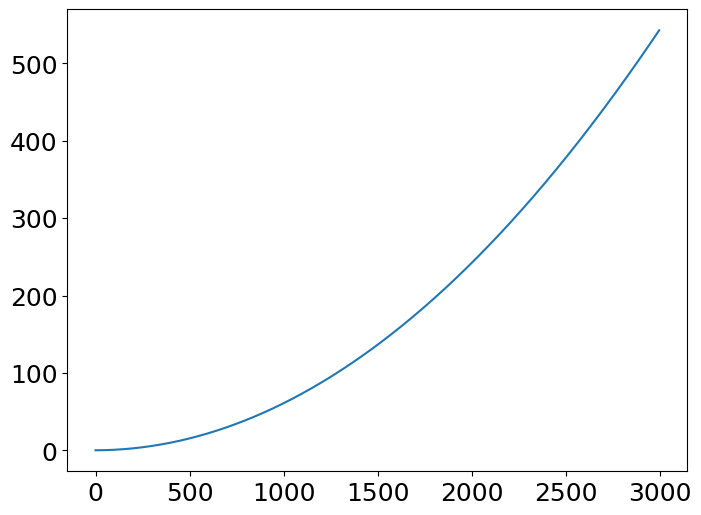

In [10]:
plt.plot(band)

## Calculate and save gpwv values through all bands 
The following cells take portion of previous nbs and calculate gpwv values for each band and then save them into a dictionary where they can be called to plot.

In [11]:
#South Pole Dict, run once
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
spole_dict={}
#for site in ['Pole','Atacama']:
for pwv in atmos['Pole'].keys():
    spole_dict[pwv]={}
    for ch in chlist:
        spole_dict[pwv][ch]={}
        
        dnu = sim['channels'][ch]['nu_high']-sim['channels'][ch]['nu_low']
        nu0 = sim['channels'][ch]['band_center']
        freqvec = atmos['Pole'][pwv][0]
        tbvec = atmos['Pole'][pwv][1]
        model1 = logistic_bandmodel(freqvec, nu0, dnu, a, n)*alpha_bandmodel(freqvec, nu0, alpha)
        #pwv2= pwv+100
        dPdpwv = calc_dPdpwv(atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], nu0, dnu, a, n, alpha)
        dPdTcmb = calc_dPdTcmb(atmos['Pole'][300][0], atmos['Pole'][400][0], nu0, dnu, a, n, alpha)
        gpwv= dPdpwv/dPdTcmb
        
    
        spole_dict[pwv][ch]['freqvec']= freqvec
        spole_dict[pwv][ch]['tbvec']= tbvec
        spole_dict[pwv][ch]['high_edge_0']= sim['channels'][ch]['nu_high']
        spole_dict[pwv][ch]['low_edge_0']= sim['channels'][ch]['nu_low']
        spole_dict[pwv][ch]['bandshape']= model1
        spole_dict[pwv][ch]['nu0']= nu0
        spole_dict[pwv][ch]['dPdTcmb']= dPdTcmb
        spole_dict[pwv][ch]['dPdpwv']= dPdpwv
        spole_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)

In [12]:
#spole_dict[300]

In [13]:
#Atacama dict, run once
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
atacama_dict={}
#for site in ['Pole','Atacama']:
for pwv in atmos['Atacama'].keys(): #can always add more pwv files and change functions below to [pwv] instead of [900]
    atacama_dict[pwv]={}
    for ch in chlist:
        atacama_dict[pwv][ch]={}
        dnu = sim['channels'][ch]['nu_high']-sim['channels'][ch]['nu_low']
        nu0 = sim['channels'][ch]['band_center']
        freqvec = atmos['Atacama'][pwv][0]
        tbvec = atmos['Atacama'][pwv][1]
        model1 = logistic_bandmodel(freqvec, nu0, dnu, a, n)*alpha_bandmodel(freqvec, nu0, alpha)
        
        dPdpwv = calc_dPdpwv(atmos['Atacama'][900][0], atmos['Atacama'][1000][0], atmos['Atacama'][900][1], atmos['Atacama'][1000][1], nu0, dnu, a, n, alpha)
        dPdTcmb = calc_dPdTcmb(atmos['Atacama'][900][0], atmos['Atacama'][1000][0], nu0, dnu, a, n, alpha)
        gpwv= dPdpwv/dPdTcmb
        
    
        atacama_dict[pwv][ch]['freqvec']= freqvec
        atacama_dict[pwv][ch]['tbvec']= tbvec
        atacama_dict[pwv][ch]['high_edge_0']= sim['channels'][ch]['nu_high']
        atacama_dict[pwv][ch]['low_edge_0']= sim['channels'][ch]['nu_low']
        atacama_dict[pwv][ch]['bandshape']= model1
        atacama_dict[pwv][ch]['nu0']= nu0
        atacama_dict[pwv][ch]['dPdTcmb']= dPdTcmb
        atacama_dict[pwv][ch]['dPdpwv']= dPdpwv
        atacama_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)

In [14]:
#atacama_dict[900]

## Next Steps: Plotting and Data Visualization

Text(0.5, 1.0, 'Pole: All Bands with Model 1')

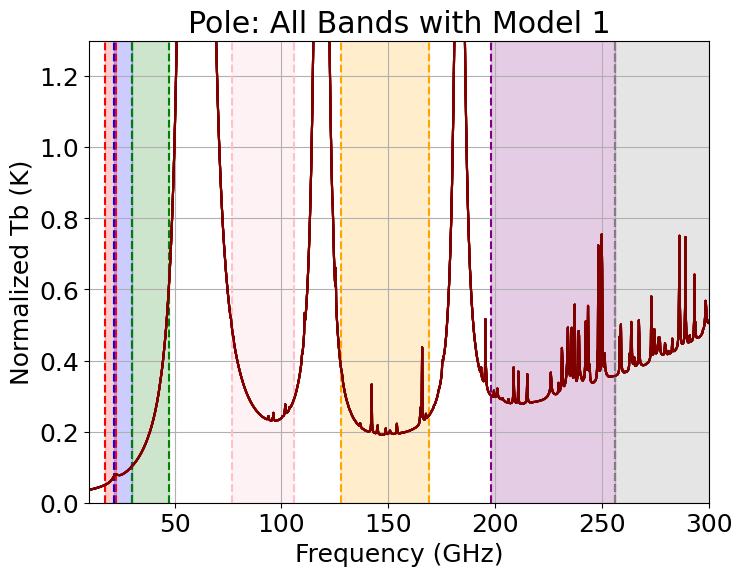

In [20]:
bandtype_dict= {'ULF':'red', 'LF_1': 'blue', 'LF_2': 'green', 'MF_1': 'pink', 'MF_2': 'orange', 'HF_1': 'purple', 'HF_2': 'grey'}
bandarray=list(bandtype_dict.keys())

#for band in bands['SAT'].keys():
    
for ch in chlist:   
    btype=bandtype_dict[ch]
    x1=spole_dict[300][ch]['high_edge_0']
    x2=spole_dict[300][ch]['low_edge_0']
    plt.axvline(x = x1, color=btype, linestyle='dashed', markersize= 0.5)#, label = 'upper band edge')
    plt.axvline(x = x2, color=btype, linestyle='dashed', markersize= 0.5)
        #plt.fill_between(x1, x2, color='blue', alpha=.2)
    plt.axvspan(x1, x2, alpha=0.2, color=btype) 
    
    #plt.plot(spole_dict[300][ch]['freqvec'], spole_dict[300][ch]['bandshape'], color=btype, label='Logistic Band Model')
    plt.plot(spole_dict[300][ch]['freqvec'], spole_dict[300][ch]['tbvec']/50, color='maroon', linestyle='solid', markersize= 0.15)
#note that model 1 includes optics/lyot info and instrumentation info
plt.xlim(10, 300)
plt.ylim(0, 1.3)
plt.grid()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Normalized Tb (K)')
plt.title('Pole: All Bands with Model 1')

Text(0.5, 1.0, 'Atacama: All Bands with Model 1')

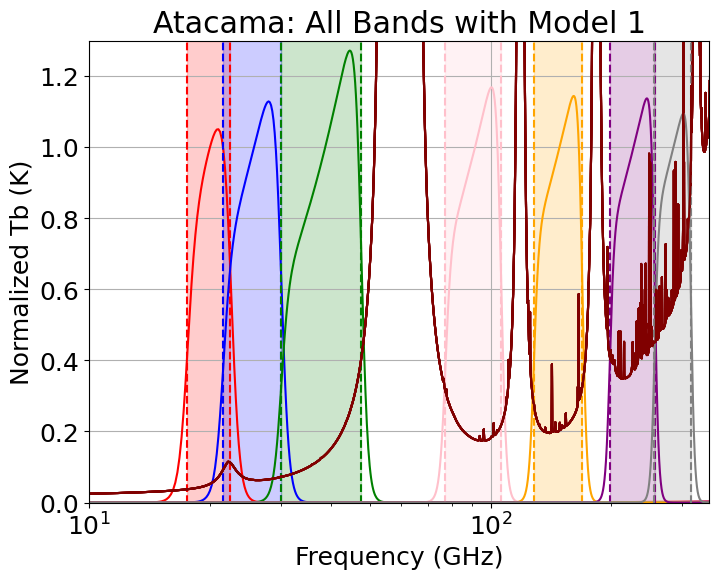

In [50]:
bandtype_dict= {'ULF':'red', 'LF_1': 'blue', 'LF_2': 'green', 'MF_1': 'pink', 'MF_2': 'orange', 'HF_1': 'purple', 'HF_2': 'grey'}
bandarray=list(bandtype_dict.keys())

#for band in bands['SAT'].keys():
    
for ch in chlist:   
    btype=bandtype_dict[ch]
    x1=atacama_dict[900][ch]['high_edge_0']
    x2=atacama_dict[900][ch]['low_edge_0']
    plt.axvline(x = x1, color=btype, linestyle='dashed', markersize= 0.5)#, label = 'upper band edge')
    plt.axvline(x = x2, color=btype, linestyle='dashed', markersize= 0.5)
        #plt.fill_between(x1, x2, color='blue', alpha=.2)
    plt.axvspan(x1, x2, alpha=0.2, color=btype) 
    
    plt.semilogx(atacama_dict[900][ch]['freqvec'], atacama_dict[900][ch]['bandshape'], color=btype, label='Logistic Band Model')
    plt.semilogx(atacama_dict[900][ch]['freqvec'], atacama_dict[900][ch]['tbvec']/50, color='maroon', linestyle='solid', markersize= 0.15)
#note that model 1 includes optics/lyot info and instrumentation info
plt.xlim(10, 350)
plt.ylim(0, 1.3)
plt.grid()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Normalized Tb (K)')
plt.title('Atacama: All Bands with Model 1')



## Edge Placement with new Functions
The cells below display results from two edge functions one high and one low. It allows us to look at the edges of our observing bands, similar to previous functions above, but we add in high/low band edges and remove the center frequency.

By properly using these functions we can adjust the dictionaries above for the two sites with not only gpwv values but also the gpwv values as a function of high and low edges.

In [6]:
#this function returns 3 arrays
dPdTcmb_h, dPdpwv_h = calc_highedgevalues(sim['channels']['LF_1']['nu_low'], sim['channels']['LF_1']['nu_high'], atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], dnu, 2, 0.7, 2)
gpwv_h = dPdpwv_h/dPdTcmb_h

In [21]:
#print(gpwv_h)

In [22]:
#this function returns 3 arrays
dPdTcmb_l, dPdpwv_l = calc_lowedgevalues(sim['channels']['LF_1']['nu_low'], sim['channels']['LF_1']['nu_high'], atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], dnu, 2, 0.7, 2)
gpwv_l=dPdpwv_l/dPdTcmb_l
#print(gpwv_l)

## Two New Dictionaries
One dict for Pole and one dict for Atacama.  These hold all the information needed for gpwv values and edges.

In [24]:
# NEW South Pole Dict, run once
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
spole_dict={}
#for site in ['Pole','Atacama']:
for pwv in atmos['Pole'].keys(): #can always add more pwv files and change functions below to [pwv] instead of [300] and [pwv+100] instead of [400]
    spole_dict[pwv]={}
    for ch in chlist:
        spole_dict[pwv][ch]={}
        npts=50 #make sure this is same as in function
        
        nu_low = sim['channels'][ch]['nu_low']
        nu_high = sim['channels'][ch]['nu_high']
        dnu = nu_high-nu_low
        nu0 = sim['channels'][ch]['band_center']
        freqvec = atmos['Pole'][pwv][0]
        freqvec_low= np.linspace(nu_low-(nu_low*0.1), nu_low+(nu_low*0.1), npts)
        freqvec_high= np.linspace(nu_high-(nu_high*0.1), nu_high+(nu_high*0.1), npts)
        
        tbvec = atmos['Pole'][pwv][1]
        model1 = logistic_bandmodel(freqvec, nu0, dnu, a, n)*alpha_bandmodel(freqvec, nu0, alpha)
        
        dPdpwv = calc_dPdpwv(atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], nu0, dnu, a, n, alpha)
        dPdTcmb = calc_dPdTcmb(atmos['Pole'][300][0], atmos['Pole'][400][0], nu0, dnu, a, n, alpha)
        gpwv = dPdpwv/dPdTcmb
        
        dPdTcmb_l, dPdpwv_l = calc_lowedgevalues(sim['channels'][ch]['nu_low'], sim['channels'][ch]['nu_high'], atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], dnu, a, n, alpha)
        gpwv_l = dPdpwv_l/dPdTcmb_l
        dPdTcmb_h, dPdpwv_h = calc_highedgevalues(sim['channels'][ch]['nu_low'], sim['channels'][ch]['nu_high'], atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], dnu, a, n, alpha)
        gpwv_h= dPdpwv_h/dPdTcmb_h
        
        spole_dict[pwv][ch]['freqvec']= freqvec
        spole_dict[pwv][ch]['lowvec']= freqvec_low
        spole_dict[pwv][ch]['highvec']=freqvec_high
        
        spole_dict[pwv][ch]['tbvec']= tbvec
        spole_dict[pwv][ch]['high_edge_0']= sim['channels'][ch]['nu_high']
        spole_dict[pwv][ch]['low_edge_0']= sim['channels'][ch]['nu_low']
        spole_dict[pwv][ch]['bandshape']= model1
        spole_dict[pwv][ch]['nu0']= nu0
        
        spole_dict[pwv][ch]['dPdTcmb'] = dPdTcmb
        spole_dict[pwv][ch]['dPdTcmb_l'] = dPdTcmb_l
        spole_dict[pwv][ch]['dPdTcmb_h'] = dPdTcmb_h
        
        spole_dict[pwv][ch]['dPdpwv'] = dPdpwv
        spole_dict[pwv][ch]['dPdpwv_l'] = dPdpwv_l
        spole_dict[pwv][ch]['dPdpwv_h'] = dPdpwv_h
        
        spole_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)
        spole_dict[pwv][ch]['gpwv_l'] = gpwv_l
        spole_dict[pwv][ch]['gpwv_h'] = gpwv_h
    

In [29]:
# NEW Atacama dict, run once
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
atacama_dict={}
#for site in ['Pole','Atacama']:
for pwv in atmos['Atacama'].keys(): #can always add more pwv files and change functions below to [pwv] instead of [900]
    atacama_dict[pwv]={}
    for ch in chlist:
        atacama_dict[pwv][ch]={}
        npts=50 #make sure this is same as in function
        
        nu_low = sim['channels'][ch]['nu_low']
        nu_high = sim['channels'][ch]['nu_high']
        dnu = nu_high-nu_low
        nu0 = sim['channels'][ch]['band_center']
        freqvec = atmos['Atacama'][pwv][0]
        freqvec_low= np.linspace(nu_low-(nu_low*0.1), nu_low+(nu_low*0.1), npts)
        freqvec_high= np.linspace(nu_high-(nu_high*0.1), nu_high+(nu_high*0.1), npts)
        
        tbvec = atmos['Atacama'][pwv][1]
        model1 = logistic_bandmodel(freqvec, nu0, dnu, a, n)*alpha_bandmodel(freqvec, nu0, alpha)
        
        dPdpwv = calc_dPdpwv(atmos['Atacama'][900][0], atmos['Atacama'][1000][0], atmos['Atacama'][900][1], atmos['Atacama'][1000][1], nu0, dnu, a, n, alpha)
        dPdTcmb = calc_dPdTcmb(atmos['Atacama'][900][0], atmos['Atacama'][1000][0], nu0, dnu, a, n, alpha)
        gpwv = dPdpwv/dPdTcmb
        
        dPdTcmb_l, dPdpwv_l = calc_lowedgevalues(sim['channels'][ch]['nu_low'], sim['channels'][ch]['nu_high'], atmos['Atacama'][900][0], atmos['Atacama'][1000][0], atmos['Atacama'][900][1], atmos['Atacama'][1000][1], dnu, a, n, alpha)
        gpwv_l = dPdpwv_l/dPdTcmb_l
        dPdTcmb_h, dPdpwv_h = calc_highedgevalues(sim['channels'][ch]['nu_low'], sim['channels'][ch]['nu_high'], atmos['Atacama'][900][0], atmos['Atacama'][1000][0], atmos['Atacama'][900][1], atmos['Atacama'][1000][1], dnu, a, n, alpha)
        gpwv_h= dPdpwv_h/dPdTcmb_h
        
        atacama_dict[pwv][ch]['freqvec']= freqvec
        atacama_dict[pwv][ch]['lowvec']= freqvec_low
        atacama_dict[pwv][ch]['highvec']=freqvec_high
        
        atacama_dict[pwv][ch]['tbvec']= tbvec
        atacama_dict[pwv][ch]['high_edge_0']= sim['channels'][ch]['nu_high']
        atacama_dict[pwv][ch]['low_edge_0']= sim['channels'][ch]['nu_low']
        atacama_dict[pwv][ch]['bandshape']= model1
        atacama_dict[pwv][ch]['nu0']= nu0
        
        atacama_dict[pwv][ch]['dPdTcmb'] = dPdTcmb
        atacama_dict[pwv][ch]['dPdTcmb_l'] = dPdTcmb_l
        atacama_dict[pwv][ch]['dPdTcmb_h'] = dPdTcmb_h
        
        atacama_dict[pwv][ch]['dPdpwv'] = dPdpwv
        atacama_dict[pwv][ch]['dPdpwv_l'] = dPdpwv_l
        atacama_dict[pwv][ch]['dPdpwv_h'] = dPdpwv_h
        
        atacama_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)
        atacama_dict[pwv][ch]['gpwv_l'] = gpwv_l
        atacama_dict[pwv][ch]['gpwv_h'] = gpwv_h

## Visualizing these results

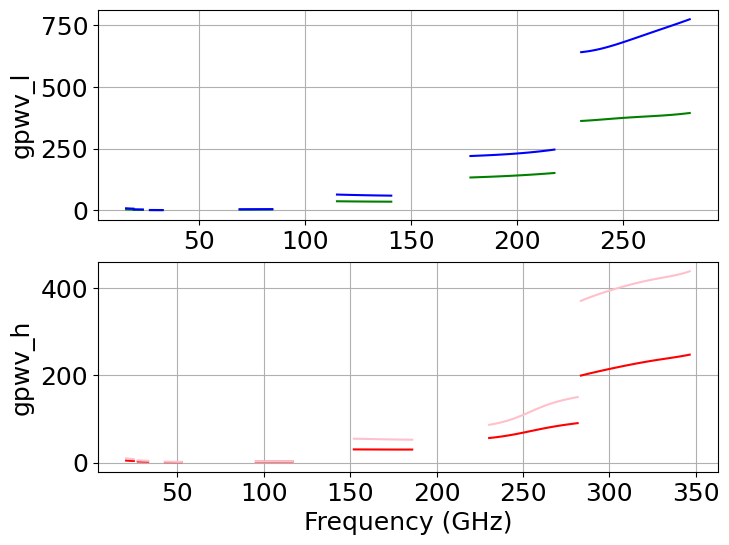

In [39]:
#comparison of the two sites and their respective gpwv high and low values
plt.subplot(2,1,1)
for ch in chlist:
    plt.plot(atacama_dict[900][ch]['lowvec'], atacama_dict[900][ch]['gpwv_l'], color='green')
    plt.plot(spole_dict[300][ch]['lowvec'], spole_dict[300][ch]['gpwv_l'], color='blue')
plt.ylabel('gpwv_l')
plt.grid()

plt.subplot(2,1,2)
for ch in chlist:
    plt.plot(atacama_dict[900][ch]['highvec'], atacama_dict[900][ch]['gpwv_h'], color='red')
    plt.plot(spole_dict[300][ch]['highvec'], spole_dict[300][ch]['gpwv_h'], color='pink')
plt.ylabel('gpwv_h')
plt.xlabel('Frequency (GHz)')
plt.grid()
    
#plt.legend()

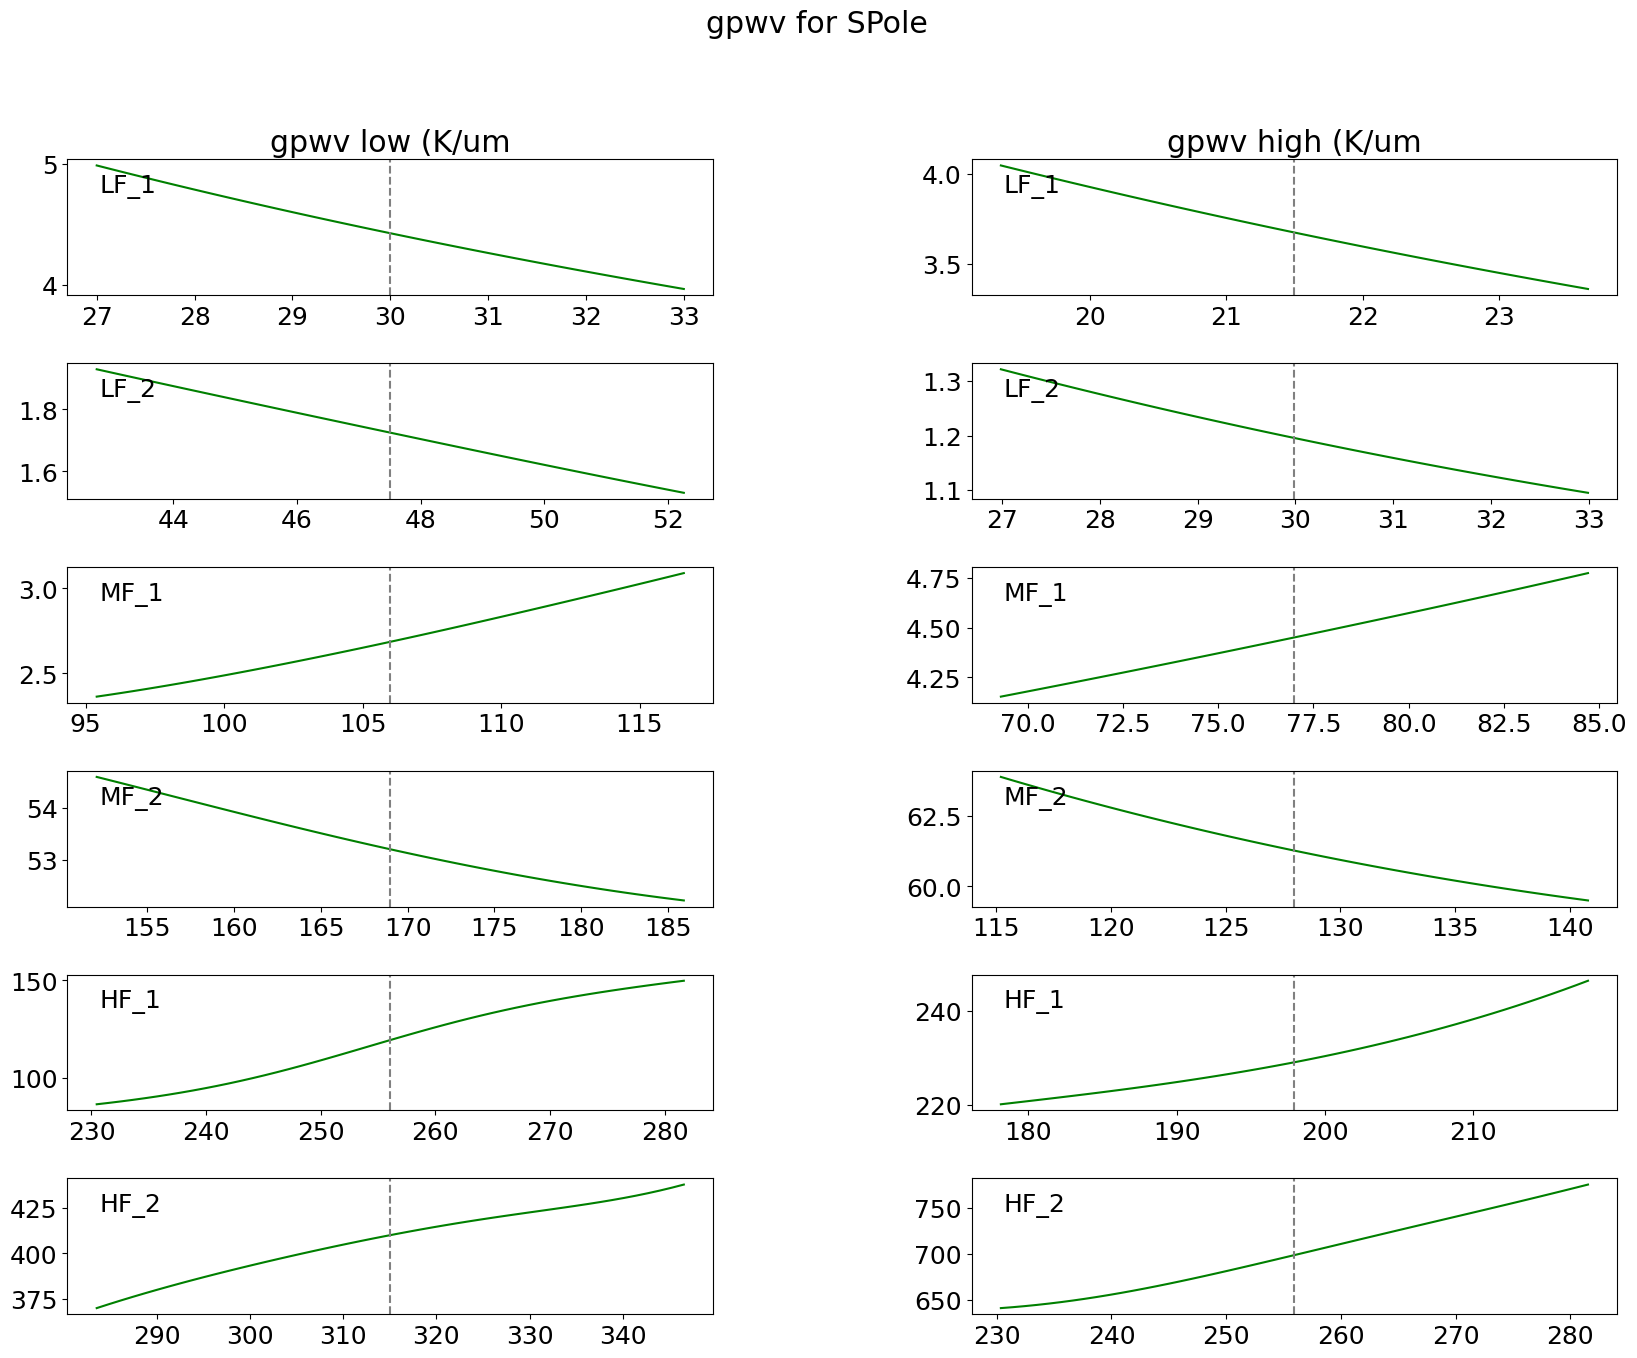

In [59]:
#SPole plots
ii1_dict= {'LF_1':0, 'LF_2':0, 'MF_1':0, 'MF_2':0, 'HF_1':0, 'HF_2':0} #'LF1':0, 'LF2':0, }
ii3_dict= {'LF_1':1, 'LF_2':1, 'MF_1':1, 'MF_2':1, 'HF_1':1, 'HF_2':1}
ii2_dict=  {'LF_1':0, 'LF_2':1, 'MF_1':2, 'MF_2':3, 'HF_1':4, 'HF_2':5} #, 'w188':1, 'w203':2, 'w204': 3, 'w206':4}
bandarray=list(ii1_dict.keys())
pwvtype_dict= {300: 'g', 900: 'r', 2200: 'b'}
figure, axis = plt.subplots(6, 2, figsize=(20,15))

figure.subplots_adjust(hspace=0.5, wspace=0.4)
figure.suptitle('gpwv for SPole')#,fontsize=20)
figure.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,
                                wspace=0.1)
axis[0,0].set_title('gpwv low (K/um)')
axis[0,1].set_title('gpwv high (K/um)')

#figure.text(0.08, 0.3, 'dt_cmb/dpwv (low)', va='center', rotation='vertical')
#figure.text(0.08, 0.7, 'dt_cmb/dpwv (high)', va='center', rotation='vertical')

Pole_pwvs= [300]
Atacama_pwvs= [900]

for pwv in Pole_pwvs:
    for ch in chlist:
        if ch != 'ULF':
            pwvtype= pwvtype_dict[pwv]
            ii1= ii1_dict[ch]
            ii2= ii2_dict[ch] 
            ii3= ii3_dict[ch] 
            axis[ii2, ii1].plot(spole_dict[pwv][ch]['highvec'], spole_dict[pwv][ch]['gpwv_h'], pwvtype, markersize= 3)
            axis[ii2, ii1].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii1].transAxes)
            axis[ii2, ii1].axvline(x = spole_dict[pwv][ch]['high_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            axis[ii2, ii3].plot(spole_dict[pwv][ch]['lowvec'], spole_dict[pwv][ch]['gpwv_l'], pwvtype, markersize= 3)
            axis[ii2, ii3].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii3].transAxes)
            axis[ii2, ii3].axvline(x = spole_dict[pwv][ch]['low_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            #axis[ii3, ii2].set_xlabel('Frequency (GHz)', loc='center')

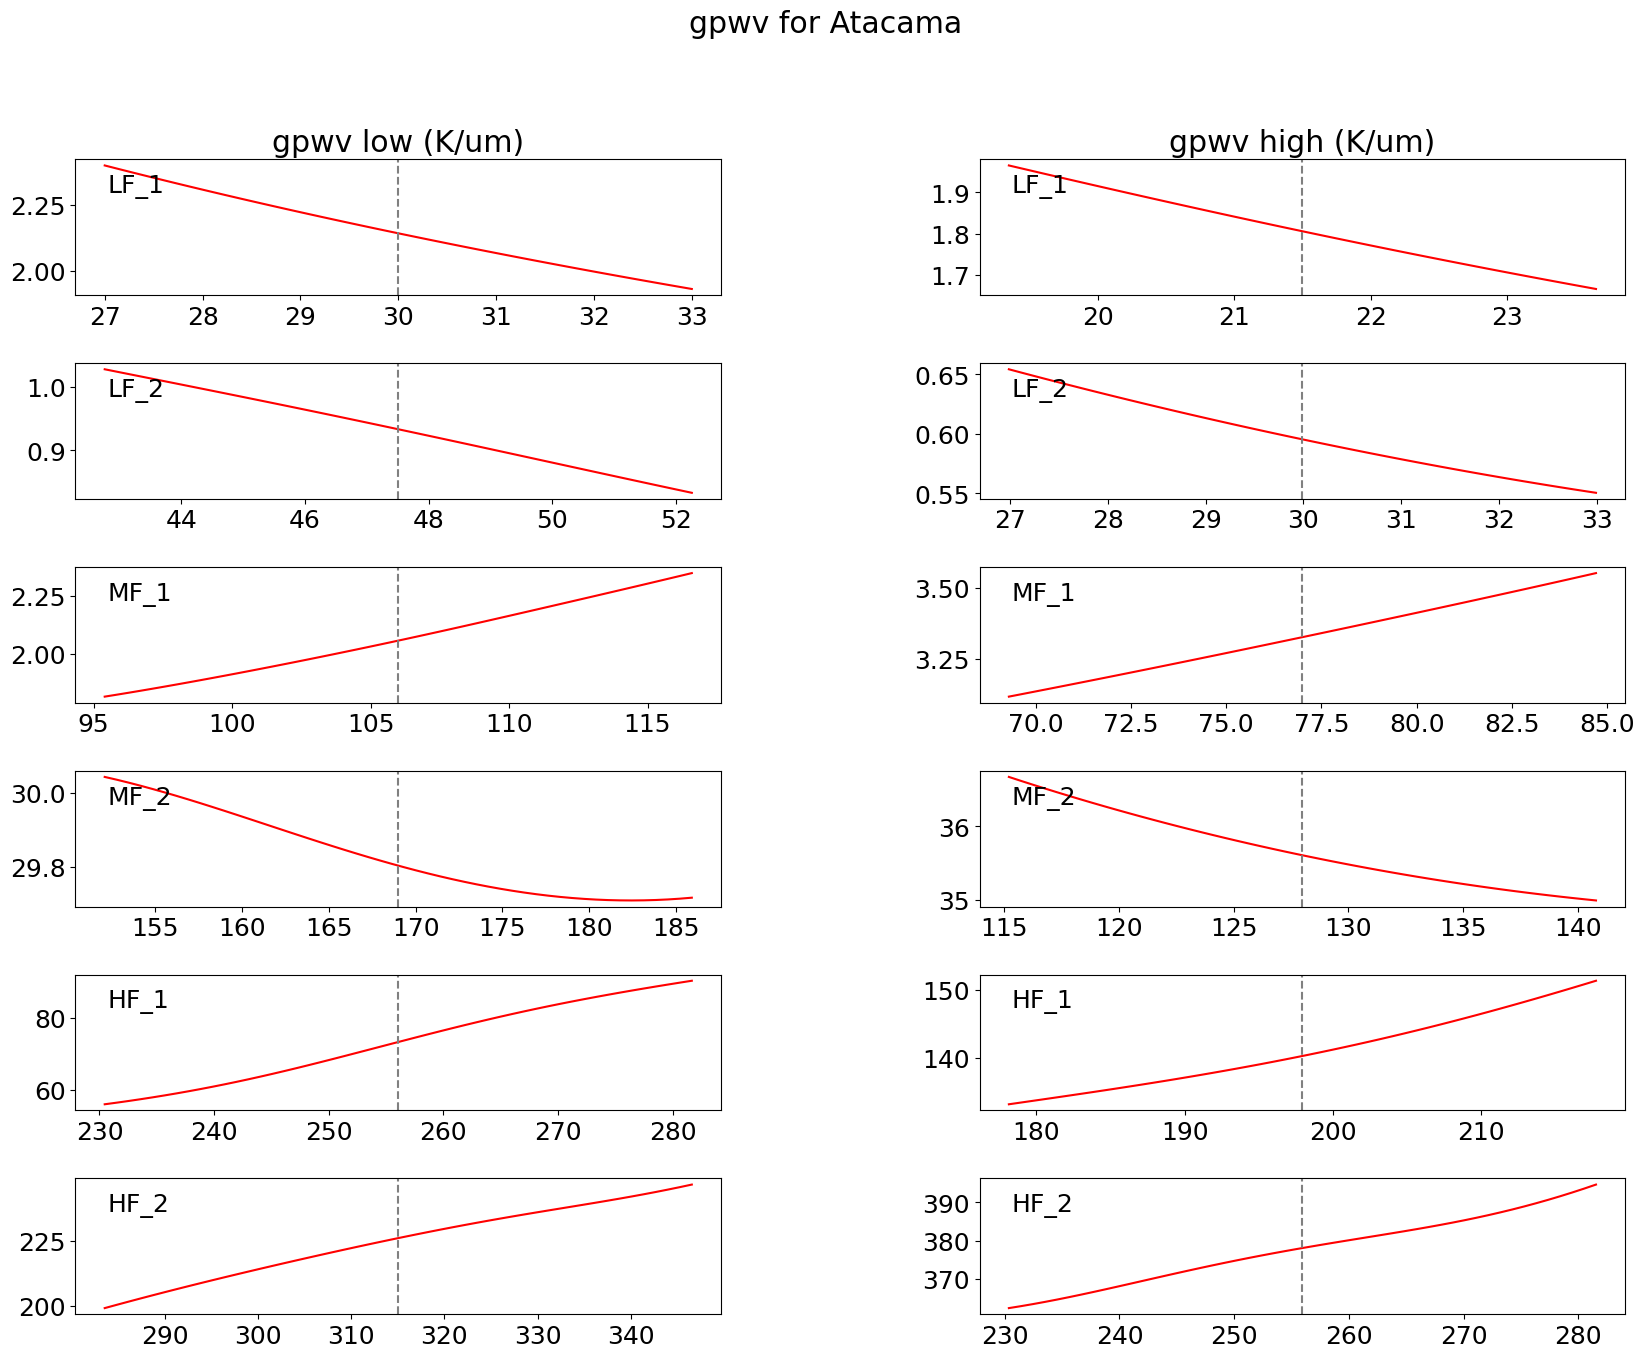

In [60]:
#Atacama plots 
ii1_dict= {'LF_1':0, 'LF_2':0, 'MF_1':0, 'MF_2':0, 'HF_1':0, 'HF_2':0} #'LF1':0, 'LF2':0, }
ii3_dict= {'LF_1':1, 'LF_2':1, 'MF_1':1, 'MF_2':1, 'HF_1':1, 'HF_2':1}
ii2_dict=  {'LF_1':0, 'LF_2':1, 'MF_1':2, 'MF_2':3, 'HF_1':4, 'HF_2':5} #, 'w188':1, 'w203':2, 'w204': 3, 'w206':4}
bandarray=list(ii1_dict.keys())
pwvtype_dict= {400: 'g', 900: 'r', 2200: 'b'}
figure, axis = plt.subplots(6, 2, figsize=(20,15))

figure.subplots_adjust(hspace=0.5, wspace=0.4)
figure.suptitle('gpwv for Atacama')#,fontsize=20)
#figure.text(0.5, 0.08, 'Frequency (GHz)', ha='center')
figure.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,
                                wspace=0.1)
axis[0,0].set_title('gpwv low (K/um)')
axis[0,1].set_title('gpwv high (K/um)')

#figure.text(0.08, 0.3, 'dt_cmb/dpwv (low)', va='center', rotation='vertical')
#figure.text(0.08, 0.7, 'dt_cmb/dpwv (high)', va='center', rotation='vertical')

Pole_pwvs= [400]
Atacama_pwvs= [900]

for pwv in Atacama_pwvs:
    for ch in chlist:
        if ch != 'ULF':
            pwvtype= pwvtype_dict[pwv]
            ii1= ii1_dict[ch]
            ii2= ii2_dict[ch] 
            ii3= ii3_dict[ch] 
            axis[ii2, ii1].plot(atacama_dict[pwv][ch]['highvec'], atacama_dict[pwv][ch]['gpwv_h'], pwvtype, markersize= 3)
            axis[ii2, ii1].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii1].transAxes)

            axis[ii2, ii1].axvline(x = atacama_dict[pwv][ch]['high_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            axis[ii2, ii3].plot(atacama_dict[pwv][ch]['lowvec'], atacama_dict[pwv][ch]['gpwv_l'], pwvtype, markersize= 3)
            axis[ii2, ii3].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii3].transAxes)
            axis[ii2, ii3].axvline(x = atacama_dict[pwv][ch]['low_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            #axis[ii2, ii3].set_xlabel('Frequency (GHz)', loc='center')